# 6 応用編

## 6.1 線形補間デモザイクの周波数特性

### はじめに

この章（応用編）ではより高度なデモザイクアルゴリズムを扱いますが、そのために若干アドバンストな数学的内容をとりあげます。

もし画像処理の数学的な側面に興味のない方は数式や信号処理的な説明の部分は読み飛ばし、コードとその使い方にお進みくださっても問題ありません。

### この節について

この節では第４章で取り上げた線形補間デモザイクの特徴について調べて次の章の準備とします。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_toc.ipynb)から参照するか、以下のリンクを使ってアクセスしてください。

https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_6_1.ipynb

### 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロードとインポート
!if [ ! -f raw_process.py ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi
from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction
from raw_process import demosaic, defect_correction, color_correction_matrix, lens_shading_correction
from raw_process import noise_filter, apply_matrix, edge_enhancement, tone_curve_correction

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'
# もし日本語が文字化けしている場合`! rm /content/.cache/matplotlib/fontList.json`を実行して、
# Runtime->Restart Runtimeで再実行

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


### 線形補間デモザイク処理の分析

_この節は、画像処理の理論的背景に興味がない方は読み飛ばして構いません。_

それではまず、前回のデモザイク処理の問題点を分析してみましょう。

前回の記事の最後で、線形補間処理をFIRフィルターとして書き換える作業を行いました。これは処理の高速化を念頭においたものですが、FIRを使った画像処理として解釈することもできます。

まず、ベイヤー配列のある特定の色の画素は、もともとのフル解像度の画像に、位置によって0または１を取るサンプリング関数を画像にかけたものと解釈する事ができます。

![ベイヤー配列上の緑画素](https://github.com/moizumi99/camera_raw_processing/raw/master/fig6_1_1.png)

これを数式で表すとこうなります。

$$ \displaystyle f_G(x, y) = f(x, y) \cdotp s(x, y) $$

$$ \displaystyle 
s(x, y) = 
\begin{cases}
0   \text{  if } x \mod 2 = y \mod 2 \\\
1  \text{  otherwise}
\end{cases}
$$

$ s(x, y) $はさらに

$$
\begin{eqnarray}
s \left ( x, y \right )  =  \frac{1}{2} \left ( 1 - \left ( -1 \right ) ^ {x + y} \right ) \\
 = \frac{1}{2} \left ( 1 - e ^ {i \pi \left ( x + y \right ) } \right )
\end{eqnarray}
$$

とかけます。
たとえば$ x $と$ y $の和が偶数だと

$$ e ^ {i \pi \left ( x + y \right )} = 1 $$

になり、奇数だと

$$ e ^ {i \pi \left ( x + y \right )} = -1 $$

になることを利用しています。

したがって、元の式は

$$
\begin{eqnarray}
f_{G} \left ( x, y \right ) =  \frac{1}{2} f_{full}\left ( 1 - \left ( -1 \right ) ^ {x + y} \right ) \\
= \frac{1}{2} \left ( f_{full} - f_{full} e ^ {i \pi \left ( x + y \right ) } \right )
\end{eqnarray}
$$

と表されます。この式の後半は、元の関数をx軸方向とy軸方向に$ \pi$ずつずらし、元の信号から引く事を意味します。

さて、この画像をフーリエ変換して周波数特性を求めたらどのようになるでしょうか？$ f_G $ をフーリエ変換したものを$ F_G $とすると、

$$
\begin{eqnarray}
F_G \left( w, v \right ) &=& \int f_G \left ( x, y \right) e ^ {i w} e ^ {i v} dx dy \\
&=& \int \frac{1}{2} \left (
    f \left( x, y \right) - f \left( x, y \right ) e ^ {\pi i \left( x + y \right) } 
    \right ) e ^ {i w} e ^ {i v} dx dy
\end{eqnarray}
$$

ここで元の$ f \left( x, y \right) $をフーリエ変換したものを $F(w, v)$とすると、

$$
F\left( w, v \right) = \int f \left( x, y  \right )  e ^ {i w x} e ^ {i v y} dx dy
$$

なので、

$$
\begin{eqnarray}
F_G \left( w, v \right ) 
&=& \frac{1}{2} F \left( x, y \right) - \frac{1}{2} \int f \left( x, y \right ) e ^ {\pi i \left( x + y \right) } 
    e ^ {i w} e ^ {i v} dx dy
\end{eqnarray}
$$

ここで、

$$
\begin{eqnarray}
\int f \left( x, y \right ) e ^ {\pi i \left( x + y \right) } e ^ {i w} e ^ {i v} dx dy
&=& \int f \left( x, y \right ) e ^ {i \left( w + \pi \right ) x } e ^ {i \left( v + \pi \right) y} dx dy \\
&=& F\left(w + \pi, v + \pi \right) 
\end{eqnarray}
$$

を利用すると

$$
F_G \left( w, v \right ) = \frac{1}{2} F\left( x, y \right) - \frac{1}{2} F\left( x + \pi, y + \pi\right)
$$

となります。

これは$\frac{1}{2}$の係数をのぞけば、元の画像の周波数特性を周波数軸上に$pi$だけずらすしてもとの画像から引いたものです。

つまり、もし元の画像の周波数特性が模式的にこのように表されるとしたら、

![元画像の周波数特性の模式図](https://github.com/moizumi99/camera_raw_processing/raw/master/fig6_1_2.png)

Bayer上の緑画素の周波数特性はこのようになります。

![エイリアスを起こした画像の周波数特性](https://github.com/moizumi99/camera_raw_processing/raw/master/fig6_1_3.png)

青い部分が、全式の後半部分にできたもので元の画像の一部を定間隔でとりだした（サブサンプリング）したためにできた副生成物（アーティファクト）です。このような副生成物をエイリアシングとよびます[^1]。

[^1]: 通常の画像で拡大縮小などによってエイリアシングがおきると、高周波成分が低い周波数に干渉してモアレなどを生成することがしられています。

画像の周波数成分は低い部分に多いと考えると、サンプリング前の信号を取り出すには、低周波部分を取り出してやれば良いことになります。
信号処理的にはローパスフィルターをかけます。

ここで、線形補間の式から作ったフィルターを思い出すと、このような形をしていました。

$$
h_1 = 
\begin{bmatrix}
    0 & 1/4 &   0 \\
  1/4 &   1 & 1/4 \\
    0 & 1/4 &   0 \\
\end{bmatrix}
$$

これはそのものズバリ、ローパスフィルターです。周波数特性はこんな感じになります。

この周波数特性はこのようになります。
$$
\begin{eqnarray}
H_1\left(w, v\right) 
&=& \sum_{x=-1}^{1} \sum_{y=-1}^{1} h_1 \left(x, y\right) e^{\pi \left(w x + v y \right)} \\
&=& \frac{1}{2} cos\left( w \right) + \frac{1}{2} cos\left( v \right) + 1
\end{eqnarray}
$$

画像として表示してみましょう。

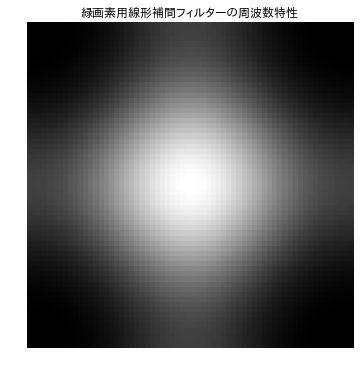

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 横軸と縦軸の位置
sample_num = 64
ws = np.linspace(-math.pi, math.pi, sample_num)
vs = np.linspace(-math.pi, math.pi, sample_num)

# wsとvsを並べたもの。
wmesh, vmesh = np.meshgrid(ws, vs, sparse=True)
# 周波数特性
f1 = np.cos(wmesh)/2 + np.cos(vmesh)/2 + 1
# パワーを求めるために２乗
f1 = f1 * f1

# pyplotのcountourfを使って表示
plt.figure(figsize=(6, 6))
plt.imshow(f1, cmap='gray')
plt.axis('off')
plt.title("緑画素用線形補間フィルターの周波数特性")
plt.show()

この図では明るい部分の値が大きく、暗い部分の値が小さくなっています。特に角の部分では０になります。

先程のベイヤー画像の緑画素の周波数特性の図と比べると、ちょうど４つの角にあるエイリアシングの部分で周波数特性が０になり打ち消すようになっていることがわかります。

同様に、赤画素のサンプリング関数は、

\begin{equation}
s_R \left ( x, y \right ) =  \frac{1}{4} \left ( 1 + \left ( -1 \right ) ^ x \right ) \left ( 1 + \left ( -1 \right ) ^ y \right ) 
=  \frac{1}{4} \left ( 1 + e ^ {i \pi x} \right ) \left ( 1 + e ^ {i \pi y} \right )  
\end{equation}

で、青画素は、

\begin{equation}
s_B \left ( x, y \right ) =  \frac{1}{4} \left ( 1 - \left ( -1 \right ) ^ x \right ) \left ( 1 - \left ( -1 \right ) ^ y \right ) 
=  \frac{1}{4} \left ( 1 - e ^ {i \pi x} \right ) \left ( 1 - e ^ {i \pi y} \right )  
\end{equation}

符号を無視すると周波数特性はどちらも同じになり、エイリアシングの様子はこうなります。

![ベイヤー内の赤・青画像の周波数特性](https://github.com/moizumi99/camera_raw_processing/raw/master/fig6_1_4.png)

緑の画素にくらべて、エイリアシングの影響を受ける領域が大きくなっています。したがって、緑よりも強めのローパスフィルターをかける必要があることが予想されます。

前回使用した赤・青画素線形補間用ののFIRフィルターはこうなっています。

$$
h_2 = 
\begin{bmatrix}
  1/4 & 1/2 & 1/4 \\
  1/2 &   1 & 1/4 \\
  1/4 & 1/2 & 1/4 \\
\end{bmatrix}
$$


周波数特性はこうです。

$$
\begin{eqnarray}
H_2\left(w, v\right) 
&=& \sum_{x=-1}^{1} \sum_{y=-1}^{1} h_2 \left(x, y\right) e^{\pi \left(w x + v y \right)} \\
&=& \left( 1 + cos\left( w \right) \right) \left( 1 + cos\left( v \right) \right)
\end{eqnarray}
$$

図示してみましょう。

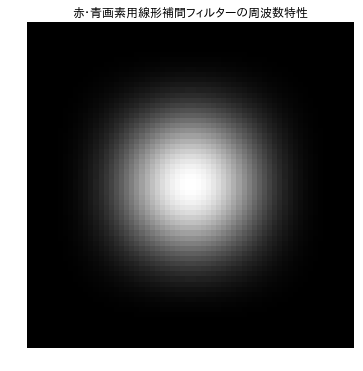

In [19]:
# 周波数特性
f2 = (1 + np.cos(wmesh)) * (1 + np.cos(vmesh))
# パワーを求めるために２乗
f2 = f2 * f2

# pyplotのcountourfを使って表示
plt.figure(figsize=(6, 6))
plt.imshow(f2, cmap='gray')
plt.axis('off')
plt.title("赤・青画素用線形補間フィルターの周波数特性")
plt.show()

ちょうと赤青画像のエイリアシングを取り除くような特性になっています。

こうしてみると理想的なフィルター処理をしているように見えますが、実際の画像はだいぶぼやけていて、偽色という本来ないはずの色がでてきています。

画像のぼやけは、もともとの画像の周波数特性を十分にカバーしていないことを、偽色の存在は本来の信号とエイリアシングとが十分に分割できていない事を示しています。
このような単純な形のフィルターの限界でしょう。

### まとめ

今回は線形補間デモザイクフィルターの周波数特性を調べてその問題点を調べてきました。

次はこういった問題点を改善した[高度なデモザイク処理](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_6_1.ipynb)に入ります。

